In [1]:
library(h2o)
library(gbm)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc

Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1


In [2]:
# Connecting to the H20 Cluster consisting of frigg and odin. It has 64 logical processors.
library(h2o)
localH2O = h2o.init(port = 5777)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         6 days 4 hours 
    H2O cluster version:        3.10.4.1 
    H2O cluster version age:    12 days  
    H2O cluster name:           denis.perevalov 
    H2O cluster total nodes:    2 
    H2O cluster total memory:   23.02 GB 
    H2O cluster total cores:    64 
    H2O cluster allowed cores:  40 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        5777 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 3.3.2 (2016-10-31) 



In [8]:
## 'path' can point to a local file, hdfs, s3, nfs, Hive, directories, etc.
df.hex <- h2o.importFile(path = "http://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/titanic.csv")

## pick a response for the supervised problem
response        <- "survived"

# H2O GBM needs it to be a factor
response_factor <- paste0(response, "_factor")
## the response variable is an integer, we will turn it into a categorical/factor for binary classification
df.hex[[response_factor]] <- as.factor(df.hex[[response]])           

## use all other columns (except for the name) as predictors
predictors <- setdiff(names(df.hex), c(response, "name", response_factor)) 

  |======================================================================| 100%


In [9]:
# Predictors for GBM
predictors_gbm = predictors[8:9]
predictors_gbm

[1] "cabin"    "embarked"

In [10]:
# Predictors for GLM
predictors_glm = setdiff(predictors, predictors_gbm)
predictors_glm

[1] "pclass"    "sex"       "age"       "sibsp"     "parch"     "ticket"   
 [7] "fare"      "boat"      "body"      "home.dest"

In [11]:
# Build GLM. It's going to be the offset
glm_model <- h2o.glm(x = predictors_glm,
                     y     = "survived",
                     family="binomial",
                     training_frame = df.hex)


  |======================================================================| 100%


In [47]:
# Get Probabilities from GLM
df.hex$Probability     = h2o.predict(glm_model, newdata = df.hex)$p1
df.hex$ProbabilityLink = log(df.hex$Probability / (1.0 - df.hex$Probability))
df.hex$ProbabilityLog  = log(df.hex$Probability)

  |======================================================================| 100%


In [96]:
# Maximum of link could be greater than 1
max(df.hex$ProbabilityLink)

[1] 2.128755

In [31]:
# Convert to R dataframe
df = as.data.frame(df.hex)

In [34]:
gbm_model  <- gbm.fit(x=df[,predictors_gbm], y=df[[response]], distribution="bernoulli", offset=df[["ProbabilityLink"]], n.trees=1000)

In [17]:
# get Probabilities
get_pred = function(model, data, type="response", offset=0, n.trees=1){
    if(class(model) == "gbm"){
        prediction = predict(model, newdata=data, type=type, n.trees = n.trees) + offset
        # If Link, convert it back to probability
        if(type == "link"){
            prediction = 1.0 / (1.0 + exp(-prediction))
        }
    }else{
        # H2O always predicts probabilities
        prediction = predict(model, newdata=data)$p1
    }
    prediction
}

# Negative Log Likelihood (Same as LogLoss)
# The lower - the better
get_nll = function(model, data, truth=NULL, offset=0, n.trees=1){
    if(is.null(truth)){
        truth = data$survived
    }
    
    prediction = get_pred(model=model, data=data, type="link", offset=offset, n.trees=n.trees)
    
    logprob    = log(prediction + 0.0000001)
    logprob2   = log(1.0 - prediction - 0.0000001)
    ytrue = as.numeric(truth)
    llk        = ytrue * logprob + (1.0 - ytrue) * logprob2
    -mean(llk)
}

In [35]:
# Calculate LogLoss for GBM
logloss  = sapply(1:1000, function(x) get_nll(gbm_model, df[,predictors_gbm], truth=df$survived, offset = df$ProbabilityLink, n.trees=x))

  |======================================================================| 100%


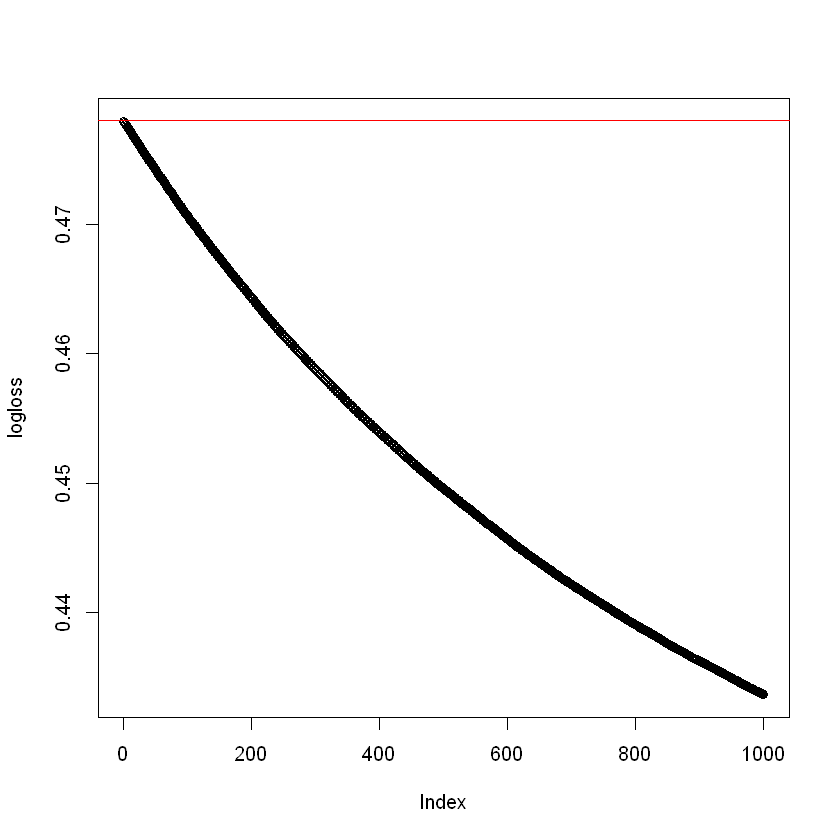

In [28]:
# Plot Log Loss for GBM as a function of trees
plot(logloss)
# Plot Log Loss for glm as red hirizontal line
abline(h=get_nll(glm_model, df.hex), col=2)

In [21]:
# Try to do the same for H2O GBM
h2o_gbm_model = h2o.gbm(x = predictors_gbm,
                         ,y                    = response_factor
                         ,distribution         = "bernoulli"
                         ,training_frame       = df.hex
                         ,ntrees               = 1
                         ,score_each_iteration = F
                         ,max_depth            = 4
                         ,learn_rate           = 0.000005
                         ,offset_column        = "ProbabilityLink"
)

  |                                                                      |   0%

water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_model_R_1489164084643_3577.  Details: ERRR on field: _offset_column: Offset cannot be larger than 1 for Bernoulli distribution.


water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_model_R_1489164084643_3577.  Details: ERRR on field: _offset_column: Offset cannot be larger than 1 for Bernoulli distribution.

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree$Driver.computeImpl(SharedTree.java:173)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:169)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1192)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(

ERROR: Error: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_model_R_1489164084643_3577.  Details: ERRR on field: _offset_column: Offset cannot be larger than 1 for Bernoulli distribution.


In [51]:
get_nll(h2o_gbm_model2, df.hex)

  |======================================================================| 100%


[1] 0.5357389

So, why is that **Offset cannot be larger than 1 for Bernoulli distribution**?

# Boston Regression Example

In [46]:

# import the boston dataset:
# this dataset looks at features of the boston suburbs and predicts         median housing prices
# the original dataset can be found at     https://archive.ics.uci.edu/ml/datasets/Housing
boston <- h2o.importFile("https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/BostonHousing.csv")

# set the predictor names and the response column name
predictors <- colnames(boston)[1:13]
# set the response column to "medv", the median value of owner-occupied     homes in $1000's
response <- "medv"

# convert the chas column to a factor (chas = Charles River dummy     variable (= 1 if tract bounds river; 0 otherwise))
boston["chas"] <- as.factor(boston["chas"])

  |======================================================================| 100%


In [53]:
# Predictors for GBM
predictors_gbm = predictors[8:9]
predictors_gbm

[1] "dis" "rad"

In [54]:
# Predictors for GLM
predictors_glm = setdiff(predictors, predictors_gbm)
predictors_glm

[1] "crim"    "zn"      "indus"   "chas"    "nox"     "rm"      "age"    
 [8] "tax"     "ptratio" "b"       "lstat"

In [58]:
# split into train and validation sets
boston.splits <- h2o.splitFrame(data =  boston, ratios = .8, seed = 1234)
train <- boston.splits[[1]]
valid <- boston.splits[[2]]

In [59]:
# Build GLM. It's going to be the offset
glm_model <- h2o.glm(x = predictors_glm,
                     y     = response,
                     family="gaussian",
                     training_frame = train,
                     validation_frame = valid
                    )


  |======================================================================| 100%


In [90]:
print(h2o.mse(glm_model, valid = TRUE))

[1] 36.95069


In [89]:
boston["offset"] <- h2o.predict(glm_model, boston)

  |======================================================================| 100%


In [91]:
head(boston)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv,offset
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,30.66602
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,26.18755
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,31.60143
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,30.01019
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,29.71509
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7,26.69434


In [92]:
# split into train and validation sets
boston.splits <- h2o.splitFrame(data =  boston, ratios = .8, seed = 1234)
train <- boston.splits[[1]]
valid <- boston.splits[[2]]

In [93]:
# try using the `offset_column` parameter:
# train your model, where you specify the offset_column
boston_gbm <- h2o.gbm(x = predictors_gbm, y = response, training_frame = train,
               validation_frame = valid,
               offset_column = "offset",
               ,ntrees               = 1
               ,score_each_iteration = F
               ,max_depth            = 4
               ,learn_rate           = 0.000005
               )

  |======================================================================| 100%


In [95]:
print(h2o.mse(glm_model, valid = TRUE))
print(h2o.mse(boston_gbm, valid = TRUE))

[1] 36.95069
[1] 36.95062


So, regression works fine